In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [5]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from evaluate import evaluate_updated
from gpmcmc import model_gp
from evaluate import half_eval as half_eval
from astropy.io import ascii

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/741107200001800")
times = lc['mjd'].data # time array
errs = lc['magerr'].data 

In [109]:
import astropy.stats as astro_stats

100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


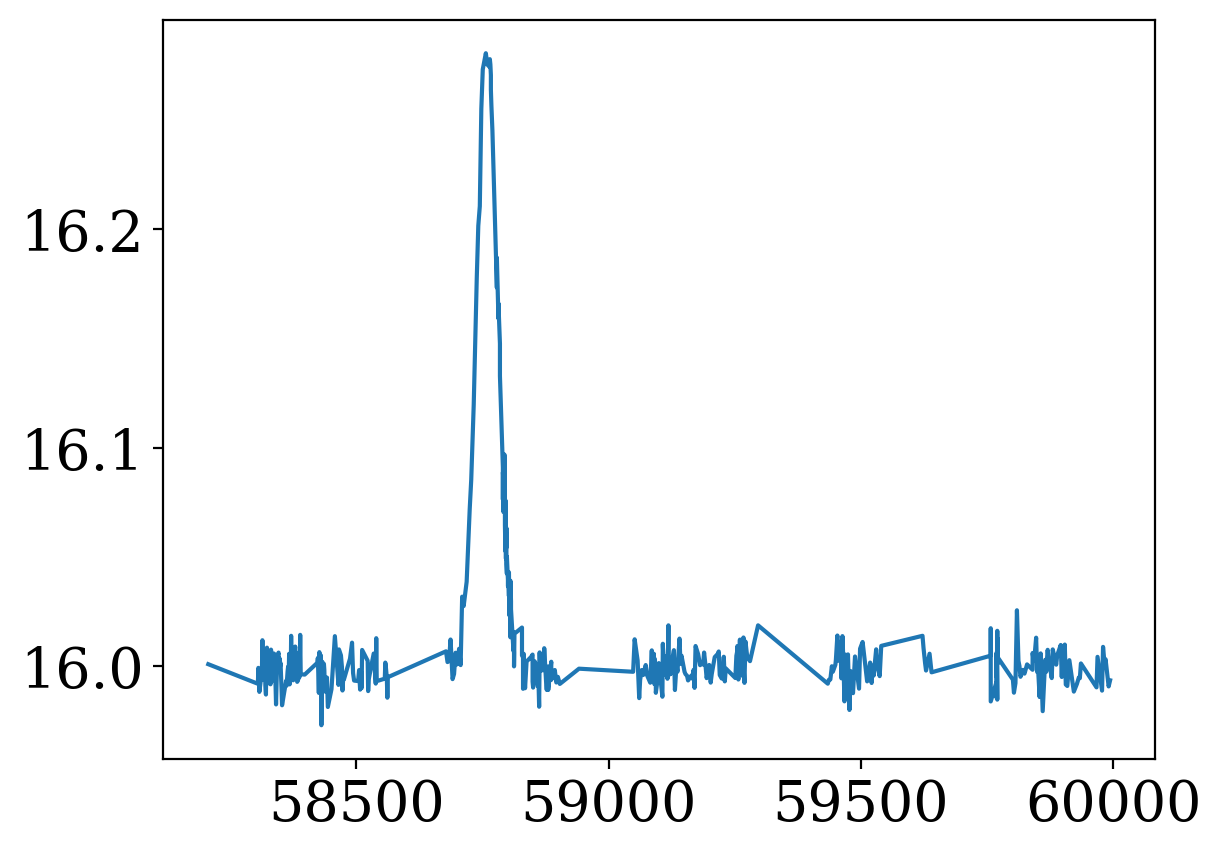

In [267]:

mz = []
sc = []
for i in tqdm(range(1)):
    mu0 = np.random.randint(min(times)+25, max(times)-25, 1)

    model = dip_models.ggd(times, mu0, 30, 2, 16, 15) + np.random.normal(0, 0.008, len(times))
    
    plt.plot(times, model)

    R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
    running_deviation = dip_pipeline.deviation(model, errs, R, S)
    peak_detections = dip_pipeline.peak_detector(times, 
                                                 running_deviation, 
                                                 power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)
    
    if peak_detections[0]==0:
        continue

    
    s = my_tools.calc_sum_score(times, model, peak_detections, R, S) # confirm that this is also consistent with the score we estimate
    sc.append(s)
    mz.append(mu0)

Text(0.5, 0, 'Injected Mean Time (m0)')

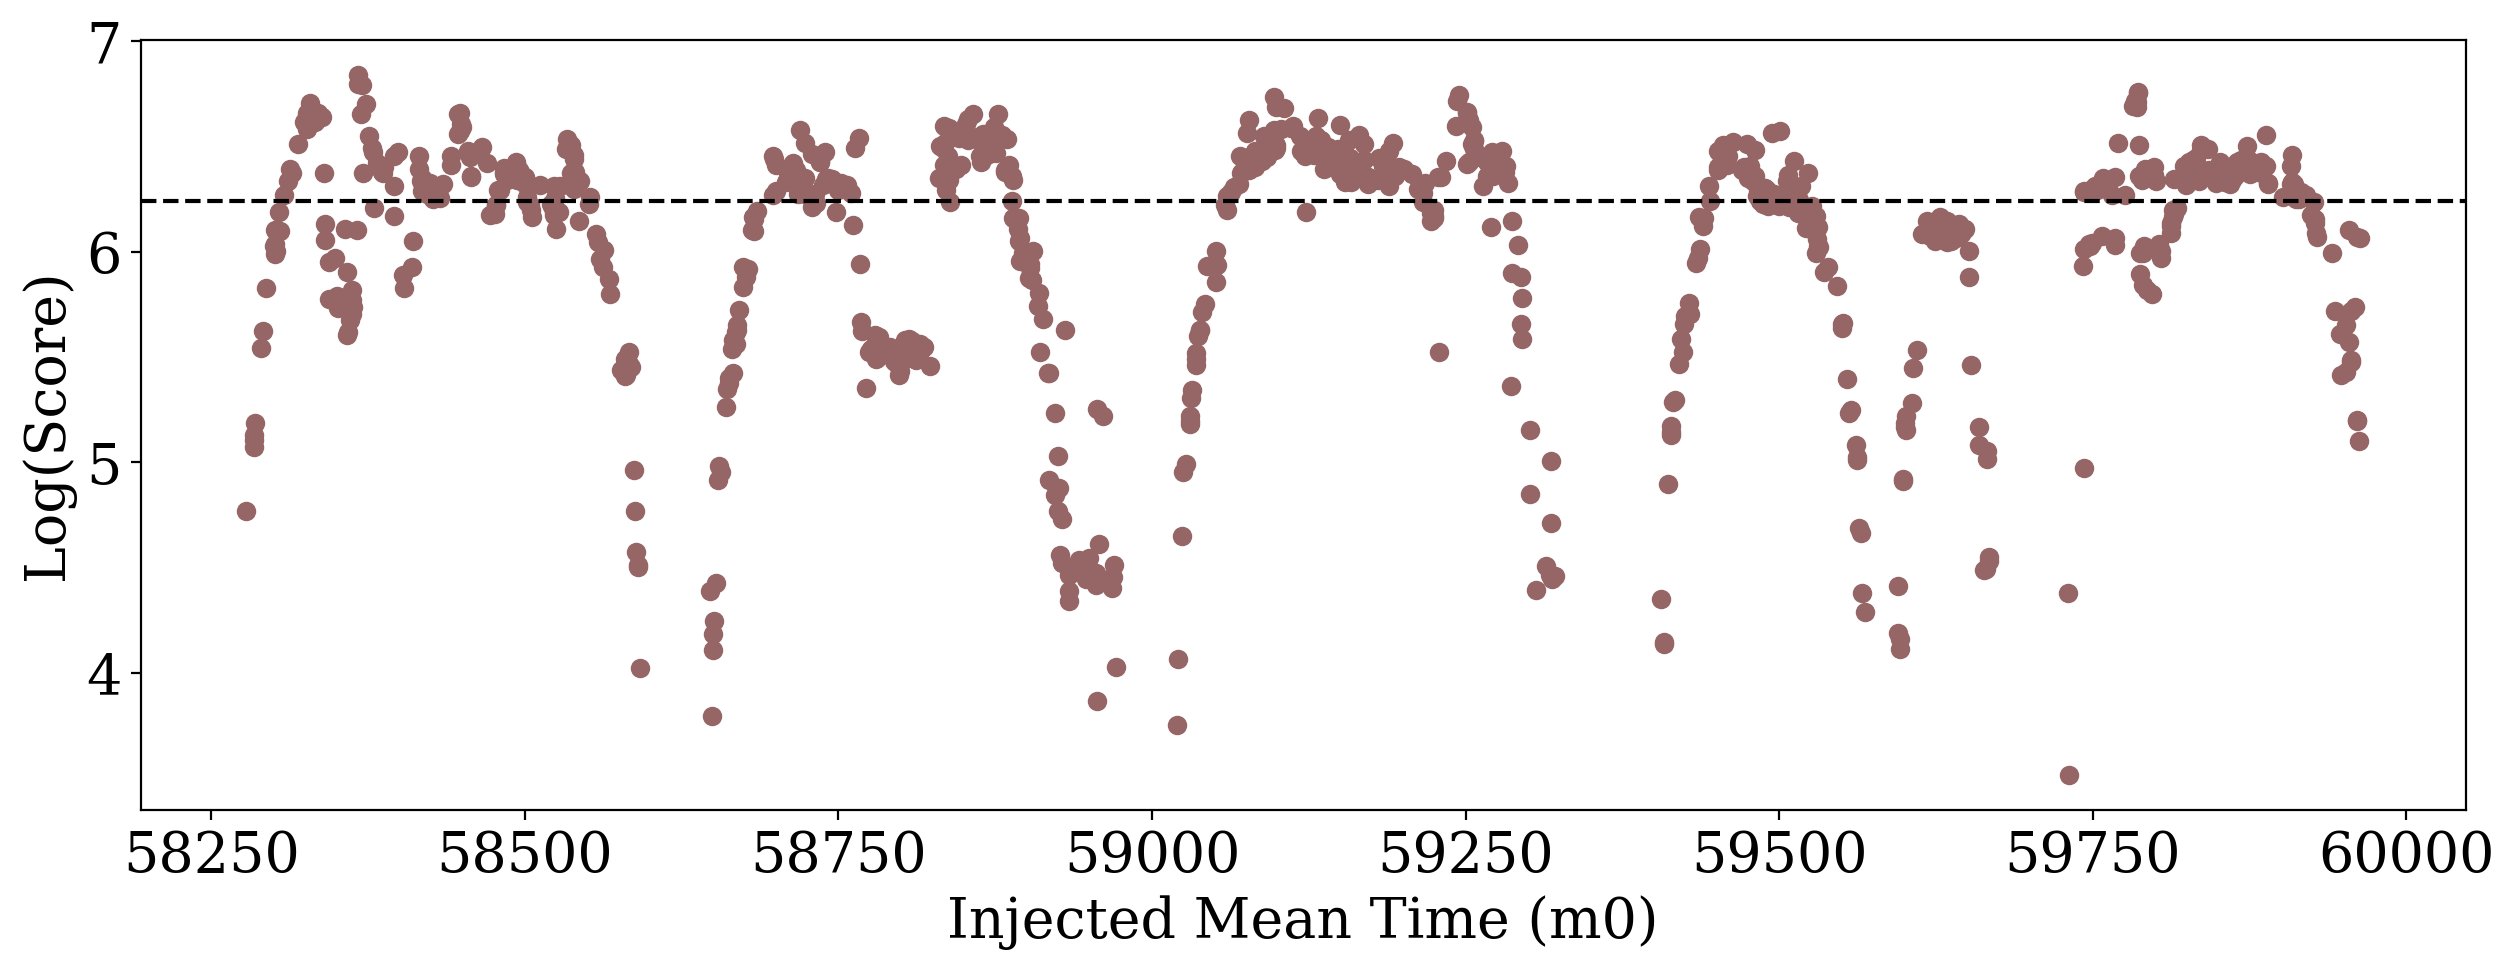

In [160]:
plt.figure(figsize=(15,5))
plt.scatter(mz, np.log10(sc), color='#966666')
plt.axhline(np.median(np.log10(sc)), 
           color='k', ls='--')
plt.ylabel("Log(Score)")
plt.xlabel("Injected Mean Time (m0)")

In [230]:
_m0 = []
_score = []
_amp = []
_sigma = []

for i in tqdm(range(2_000)):
    mu0 = np.random.randint(min(times)+25, max(times)-25, 1)
    sig, amp = np.random.randint(1, 50), np.random.randint(1, 50)
    sig += np.random.normal(0, 1)
    amp += np.random.normal(0, 1)

    model = dip_models.ggd(times, mu0, sig, 50, 16, amp) + np.random.normal(0, 0.008, len(times))

    R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
    running_deviation = dip_pipeline.deviation(model, errs, R, S)
    peak_detections = dip_pipeline.peak_detector(times, 
                                                 running_deviation, 
                                                 power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)
    
    if peak_detections[0]==0:
        _score.append(0)
        _m0.append(mu0)
        _amp.append(amp)
        _sigma.append(sig)
        
        continue

    
    s = my_tools.calc_sum_score(times, model, peak_detections, R, S) # confirm that this is also consistent with the score we estimate
    _m0.append(mu0)
    _amp.append(amp)
    _sigma.append(sig)
    _score.append(s)

100%|██████████| 2000/2000 [00:33<00:00, 60.34it/s]


Text(0.5, 0, 'Amplitude')

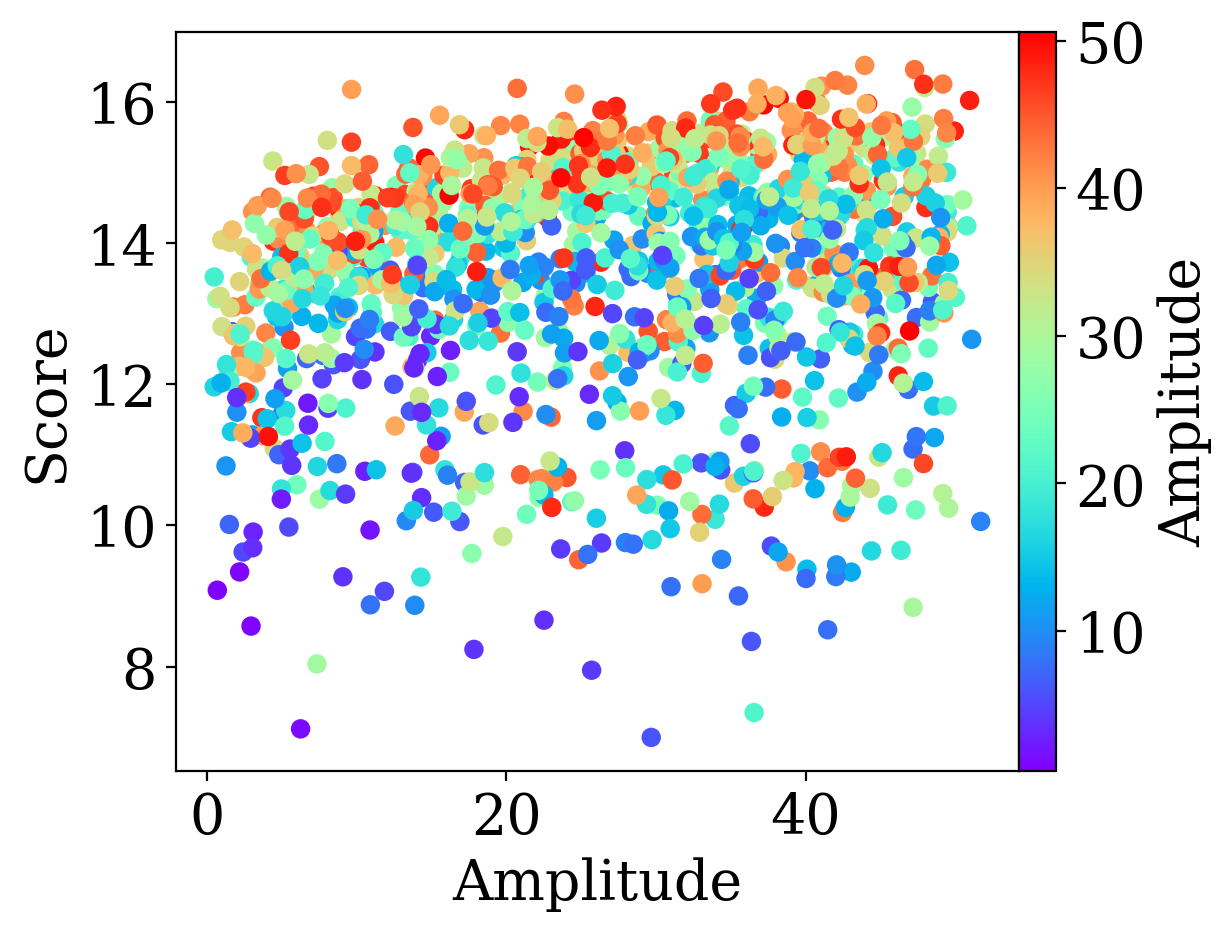

In [253]:
plt.scatter(_sigma, np.array(np.log(_score)), c=_amp, cmap='rainbow')
plt.colorbar(label='Amplitude', pad=0.0001)
plt.ylabel("Score")
plt.xlabel("Amplitude")


# Score per function of Ndips of similar amplitude

100%|██████████| 100/100 [00:00<00:00, 278.26it/s]


Text(0, 0.5, 'Log(Score)')

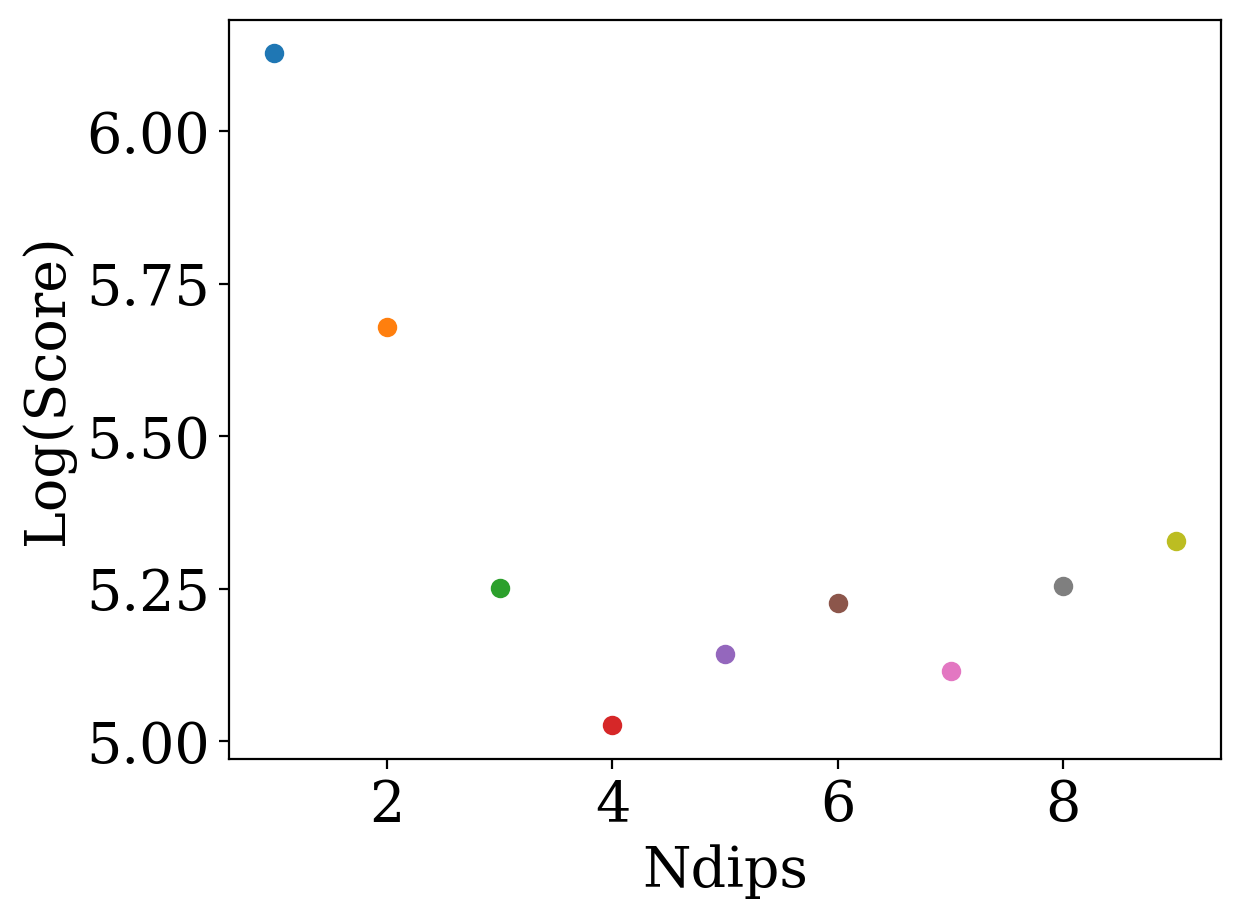

In [361]:
for j in range(1, 10):
    mz = []
    sc = []
    Ninj = []
    for i in tqdm(range(100)):
        rd = j
        model = 0 
        for i in range(rd):
            mu0 = np.random.randint(min(times)+25, max(times)-25, 1)
            model += dip_models.ggd(times, mu0, 30, 2, 16,
                                    18) 
        model /= rd
        model -= 16
        model += 16
        model += np.random.normal(0, 0.008, len(times))

        #plt.plot(times, model)

        R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
        running_deviation = dip_pipeline.deviation(model, errs, R, S)
        peak_detections = dip_pipeline.peak_detector(times, 
                                                     running_deviation, 
                                                     power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)

        if peak_detections[0]==0:
            continue


        s = my_tools.calc_sum_score(times, model, peak_detections, R, S) # confirm that this is also consistent with the score we estimate
        sc.append(s)
        Ninj.append(rd)

        
    plt.scatter(j, np.log10(np.median(sc)))
    
plt.xlabel("Ndips")
plt.ylabel("Log(Score)")

In [345]:
Ninj = np.array(Ninj)
sc = np.array(sc)

bin_score = []
Nps = []
for i in range(1, 10):
    bin_score.append(np.median(np.log10(sc[Ninj==i])))
    Nps.append(len(sc[Ninj==i]))

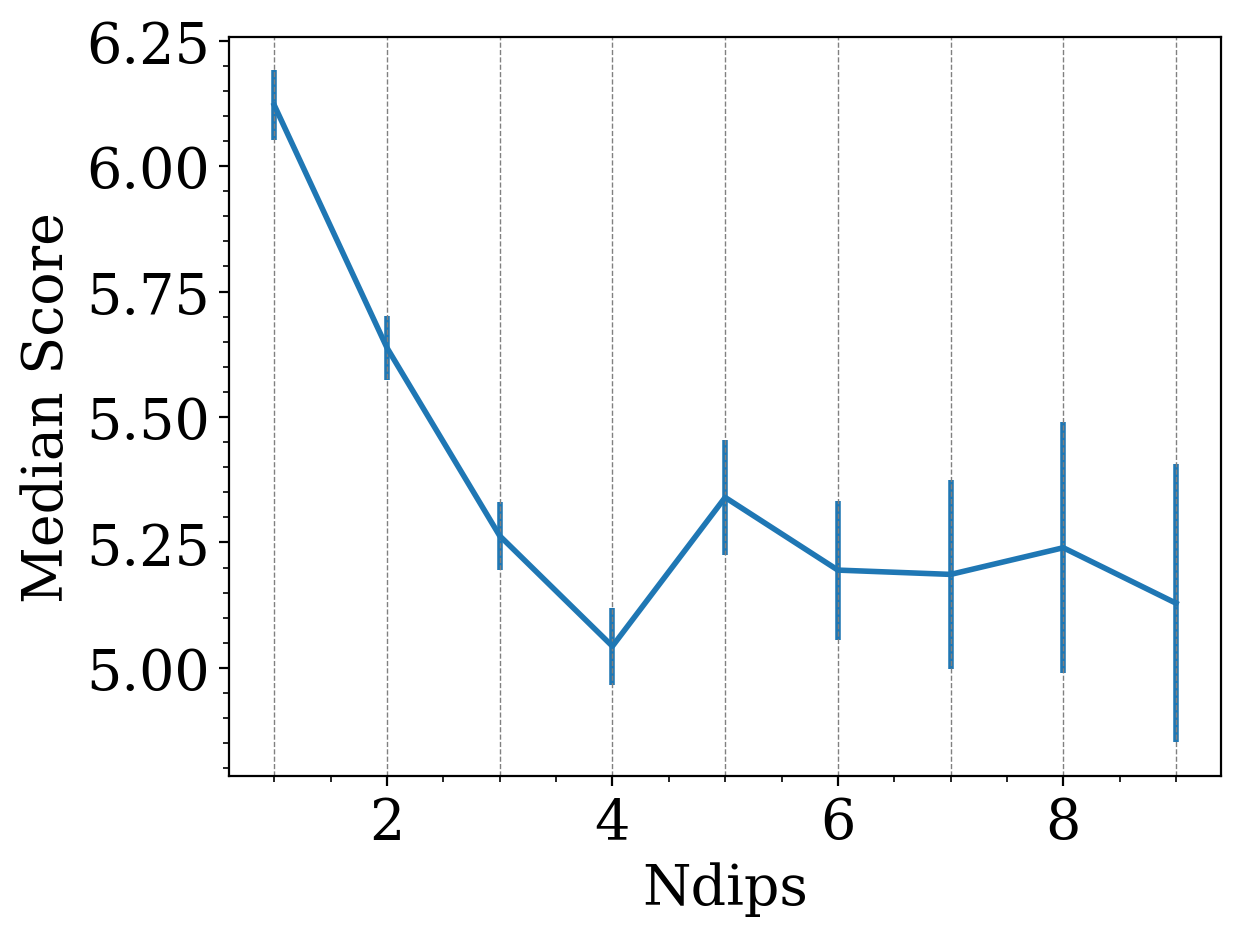

In [350]:
plt.errorbar(range(1, 10), bin_score, yerr =1/np.sqrt(Nps),  lw=2)

plt.xlabel("Ndips")
plt.ylabel("Median Score")
for i in range(1, 10):
    plt.axvline(i, ls='--', color='gray', lw=0.5)
plt.minorticks_on()

100%|██████████| 100/100 [00:00<00:00, 323.53it/s]


Text(0.5, 1.0, 'With Outliers')

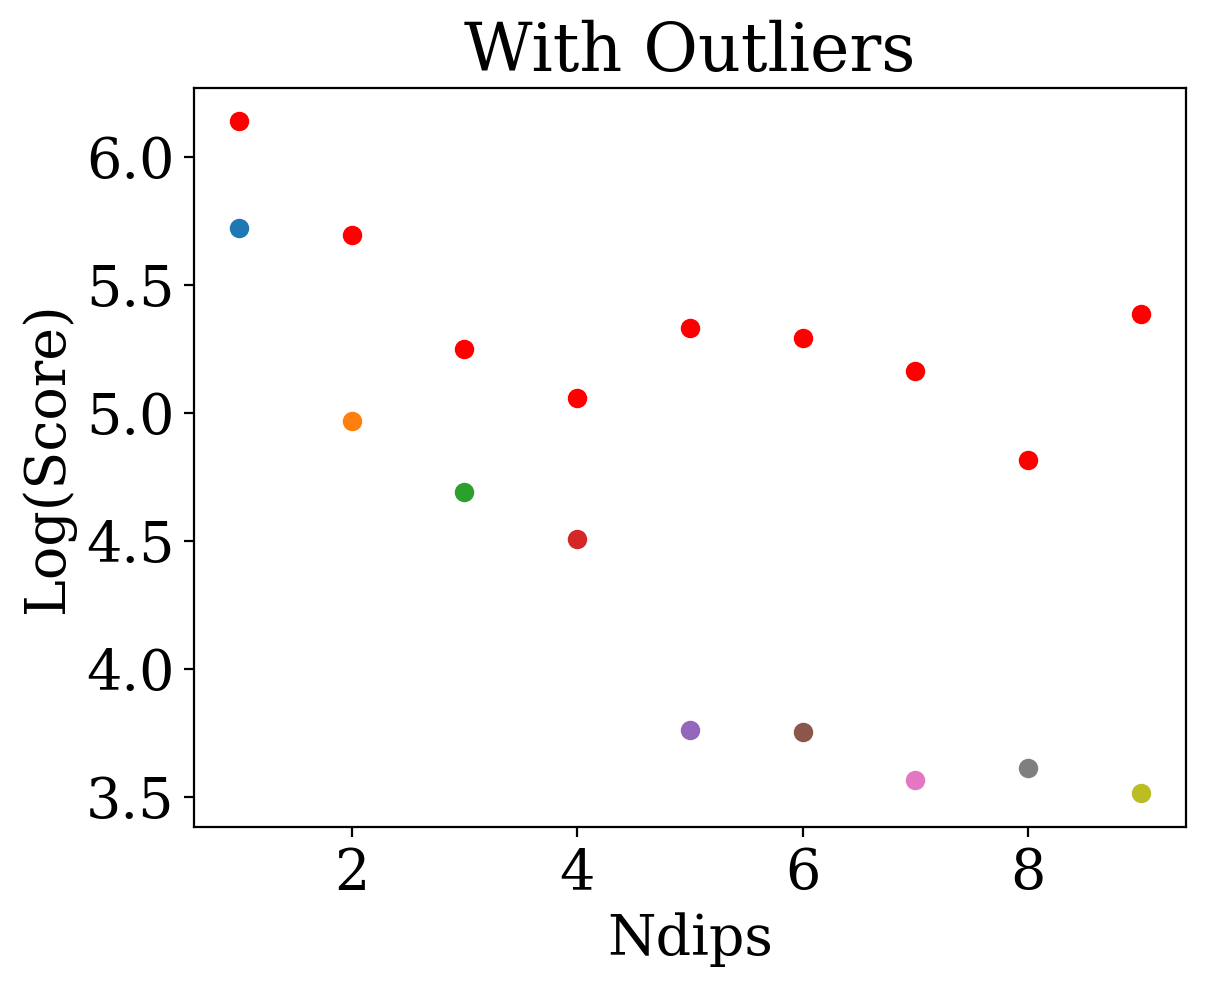

In [375]:
# inject 1-3 outliers
for j in range(1, 10):
    mz = []
    sc = []
    Ninj = []
    for i in tqdm(range(100)):
        rd = j
        model = 0 
        for i in range(rd):
            mu0 = np.random.randint(min(times)+25, max(times)-25, 1)
            model += dip_models.ggd(times, mu0, 30, 2, 16,
                                    18) 
        model /= rd
        model -= 16
        model += 16
        model += np.random.normal(0, 0.008, len(times))
        
        for _ in range(np.random.randint(1, 3)):
            model[np.random.randint(0+1, 450-1)] = 16.5 + np.random.normal(0, 0.1)

        #plt.plot(times, model)

        R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
        running_deviation = dip_pipeline.deviation(model, errs, R, S)
        peak_detections = dip_pipeline.peak_detector(times, 
                                                     running_deviation, 
                                                     power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)

        if peak_detections[0]==0:
            continue


        s = my_tools.calc_sum_score(times, model, peak_detections, R, S) # confirm that this is also consistent with the score we estimate
        sc.append(s)
        Ninj.append(rd)

        
    plt.scatter(j, np.log10(np.median(sc)))
    
    
    
    
for j in range(1, 10):
    mz = []
    sc = []
    Ninj = []
    for i in tqdm(range(100)):
        rd = j
        model = 0 
        for i in range(rd):
            mu0 = np.random.randint(min(times)+25, max(times)-25, 1)
            model += dip_models.ggd(times, mu0, 30, 2, 16,
                                    18) 
        model /= rd
        model -= 16
        model += 16
        model += np.random.normal(0, 0.008, len(times))

        #plt.plot(times, model)

        R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
        running_deviation = dip_pipeline.deviation(model, errs, R, S)
        peak_detections = dip_pipeline.peak_detector(times, 
                                                     running_deviation, 
                                                     power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)

        if peak_detections[0]==0:
            continue


        s = my_tools.calc_sum_score(times, model, peak_detections, R, S) # confirm that this is also consistent with the score we estimate
        sc.append(s)
        Ninj.append(rd)

        
    plt.scatter(j, np.log10(np.median(sc)), color='red')
    
plt.xlabel("Ndips")
plt.ylabel("Log(Score)")
plt.title("With Outliers")

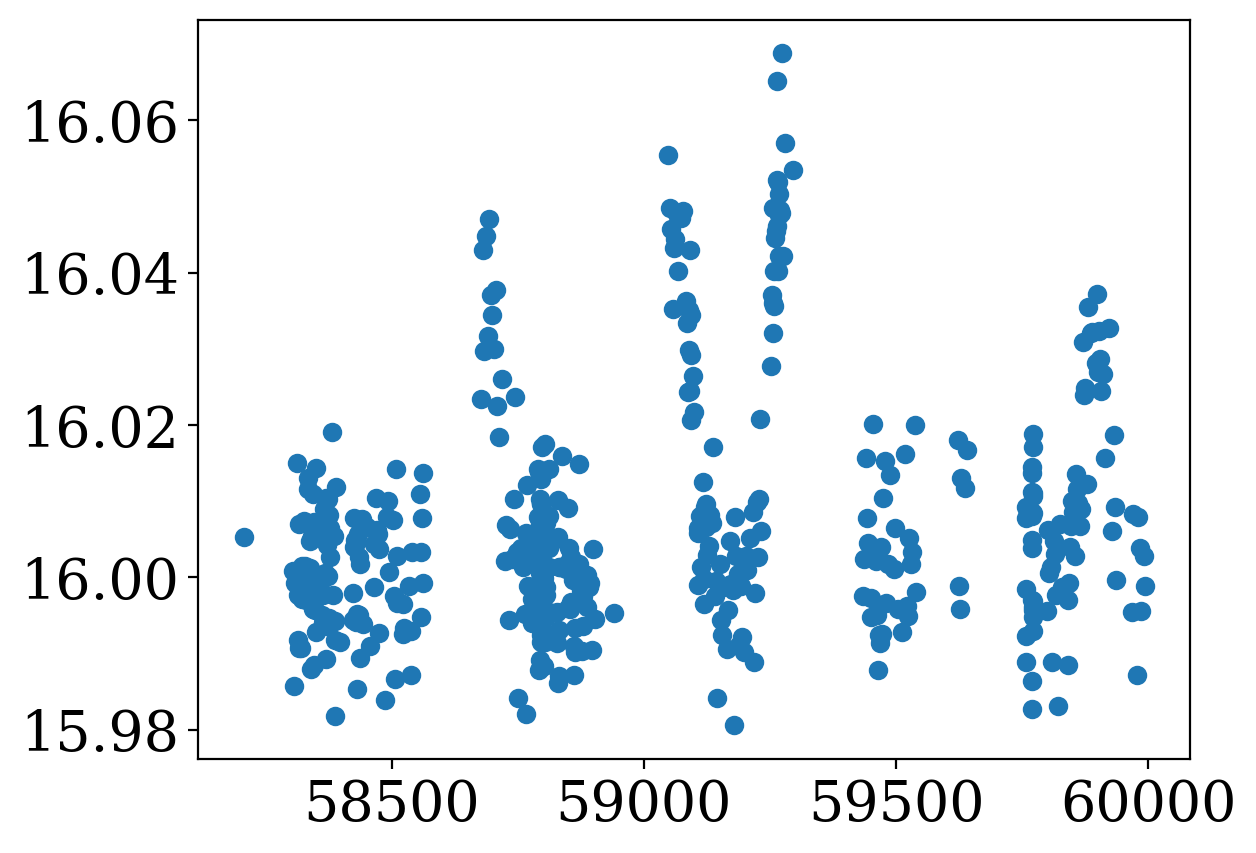

In [376]:
plt.scatter(times, model)

In [372]:
len(times)

450

In [207]:
for i in tqdm(range(1)):
    mu0 = np.random.randint(min(times)+25, max(times)-25, 1)

    model = dip_models.ggd(times, mu0, 30, 50, 16, 30) + np.random.normal(0, 0.008, len(times))
    
    R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)
    running_deviation = dip_pipeline.deviation(model, errs, R, S)
    peak_detections = dip_pipeline.peak_detector(times, 
                                                 running_deviation, 
                                                 power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)
    print (peak_detections)
    
    ev = evaluate_updated(times, model, errs, np.zeros(len(times)), 
                    np.array(['r' for _ in range(len(times))]))
    
    print (ev)


100%|██████████| 1/1 [00:00<00:00, 30.47it/s]

(1, {'dip_0': {'peak_loc': 58778.30592, 'window_start': 58712.48846, 'window_end': 58781.41331, 'N_1sig_in_dip': 22, 'N_in_dip': 22, 'loc_forward_dur': 65.81745999999839, 'loc_backward_dur': 3.1073900000046706, 'dip_power': 26.138575830911314, 'average_dt_dif': 0}})
Nphot                   377.000000
biweight_scale            0.008158
frac_above_2_sigma        0.050398
Ndips                     1.000000
rate                      0.000559
chi2dof                   1.050618
skew                      4.108842
kurtosis                 15.048401
mad                       0.005811
stetson_i             13503.808075
stetson_j               486.789302
stetson_k                 0.276656
invNeumann                0.261933
best_dip_power                 NaN
best_dip_time_loc              NaN
best_dip_start                 NaN
best_dip_end                   NaN
best_dip_dt                    NaN
best_dip_ndet                  NaN
lc_score                       NaN
dtype: float64


In [212]:
my_data_r = pd.DataFrame({"mjd": times,
                        "mag":model,
                        "mag_err": errs, 
             "catflags": np.zeros(len(times)),
                        "band": ['r' for _ in range(len(times))]})

my_data_g = pd.DataFrame({"mjd": times,
                        "mag":model,
                        "mag_err": errs, 
             "catflags": np.zeros(len(times)),
                        "band": ['g' for _ in range(len(times))]})

In [216]:
my_data = pd.concat([my_data_r, my_data_g])

In [217]:
evaluate_updated(my_data['mjd'].values, my_data['mag'].values,
                my_data['mag_err'].values, my_data['catflags'].values, 
                my_data['band'].values)

Nphot                 3.770000e+02
biweight_scale        8.157581e-03
frac_above_2_sigma    5.039788e-02
Ndips                 1.000000e+00
rate                  5.592907e-04
chi2dof               1.050618e+00
skew                  4.108842e+00
kurtosis              1.504840e+01
mad                   5.810726e-03
stetson_i             1.350381e+04
stetson_j             4.867893e+02
stetson_k             2.766565e-01
invNeumann            2.619326e-01
best_dip_power        2.607952e+01
best_dip_time_loc     5.877831e+04
best_dip_start        5.871249e+04
best_dip_end          5.878441e+04
best_dip_dt           0.000000e+00
best_dip_ndet         2.000000e+01
lc_score              4.062741e+06
dtype: float64